# Exercise 2

## Discrete random variables

### 1. Choose a value for the probability parameter p in the geometric distribution and simulate 10,000 outcomes. You can experiment with a small, moderate and large value if you like.

I simulate $n=10000$ outcomes with the in-built geometric distribution in NumPy, with the values $p_1=0.2$, $p_2=0.5$, and $p_3=0.8$ to test different values:

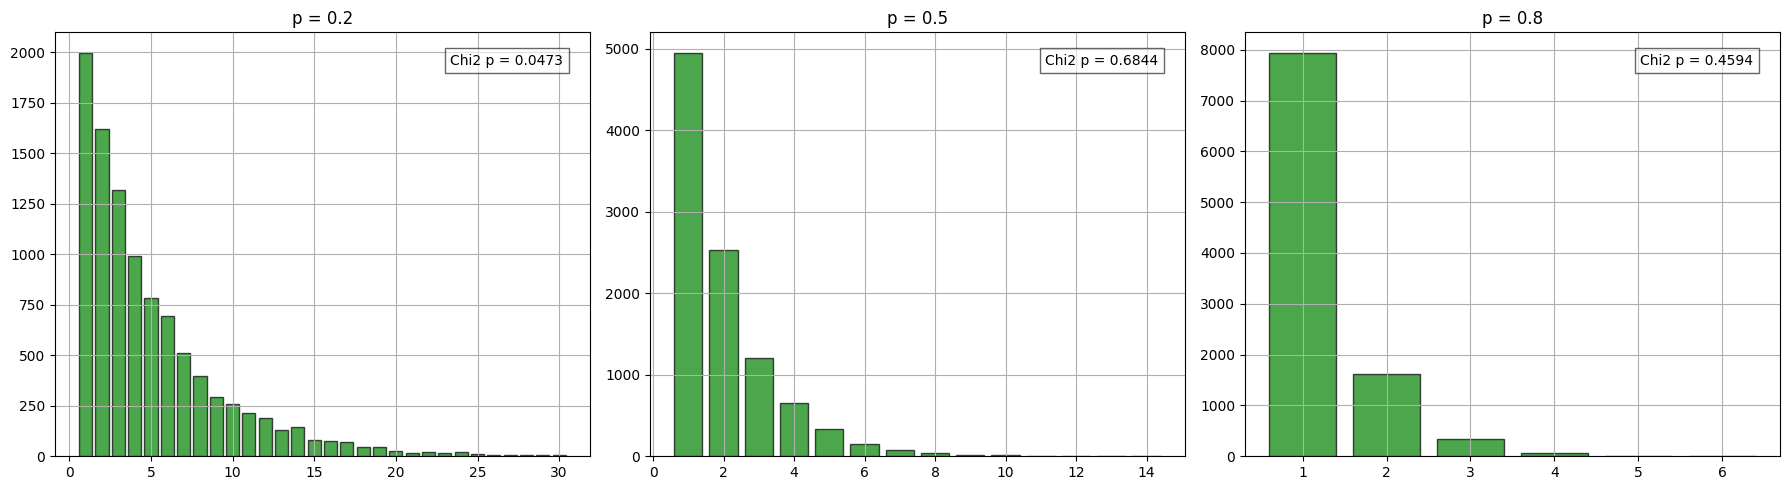

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import chisquare, kstest, geom, entropy, pareto, t, chi2, uniform
from statsmodels.sandbox.stats.runs import runstest_1samp
import time

p_values = [0.2, 0.5, 0.8]
n_samples = 10000
max_bins = 30

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, p in enumerate(p_values):
    data = np.random.geometric(p, size=n_samples)
    bins = np.arange(1, min(data.max(), max_bins) + 1)
    counts, _ = np.histogram(data, bins=np.append(bins, bins[-1]+1))
    axs[i].bar(bins, counts, width=0.8, align='center', alpha=0.7, edgecolor='black', color='green')
    axs[i].set_title(f'p = {p}')
    axs[i].grid(True)
    probs = geom.pmf(bins, p)
    expected_counts = probs * n_samples
    min_len = min(len(counts), len(expected_counts))
    expected_counts *= counts.sum() / expected_counts.sum()
    chi2_stat, p_val = chisquare(f_obs=counts[:min_len], f_exp=expected_counts[:min_len])
    axs[i].text(0.95, 0.95, f'Chi2 p = {p_val:.4f}', ha='right', va='top',
                  transform=axs[i].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

plt.tight_layout()
plt.show()



The experiments show that as $p$ increases, the distribution becomes more concentrated near 1. Additionally, the $\chi^2$ p-values indicate a good match between the simulated and theoretical distributions in all cases.

### 2. Simulate the 6 point distribution with


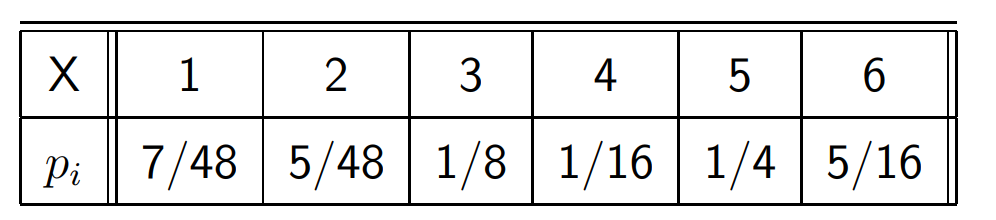



### (a) by applying a direct (crude) method
### (b) by using the the rejction method
### (c) by using the Alias method

For the 6-point distribution, we have the following:

$X=\{1,2,3,4,5,6\}$

$p_i=\{7/48,5/48,1/8,1/16,1/4,5/16\}$

We set $n=10000$

In [12]:
n = 10000
X = np.array([1, 2, 3, 4, 5, 6])
P = np.array([7/48, 5/48, 1/8, 1/16, 1/4, 5/16])
cum_P = np.cumsum(P)

U = np.random.uniform(0, 1, n)
samples = np.zeros(n, dtype=int)

def chi2_test(samples, p):

    _, n = np.unique(samples, return_counts=True)

    n_exp = p * np.sum(n)

    T = np.sum((n - n_exp)** 2 / n_exp)

    # test stat follows chi2(k - 1), week 1 slide 10
    return 1 - chi2.cdf(T, len(p) - 1)

$\textbf{(a)}$ The direct (crude) method works by dividing the unit interval $[0,1]$ into segments, where a uniform random number is generated and mapped to the corresponding interval

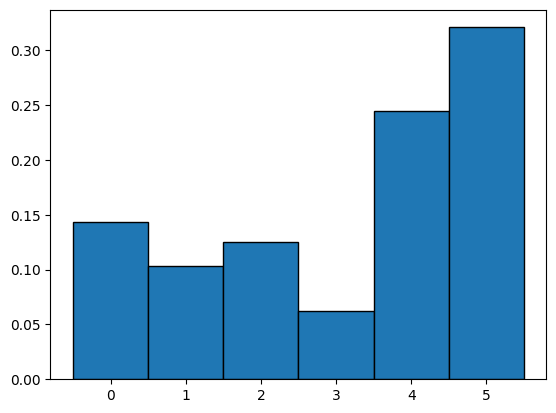

P-val (crude)    : 0.5738687365618038


In [22]:
def discrete_crude(n, p):
    # not exactly the same crude method as in the slides, but definitely crude
    us = uniform.rvs(size=n)

    vals = np.zeros_like(us)
    thresh = p[0]

    for p_i in p[1:]:
        vals += thresh < us
        thresh += p_i

    return vals

crude_vals = discrete_crude(n, P)
plt.hist(crude_vals, bins=np.arange(len(P)+1)-0.5, edgecolor='black', density=True)
plt.show()
print("P-val (crude)    :", chi2_test(crude_vals, P))

The histogram closely matches the target probabilities, with higher bars for outcomes with larger assigned probabilities, confirming that the method correctly maps uniform random values to the specified discrete distribution. Furthermore, the p-value is high, meaning the generated distribution in the method would follow a $\chi^2$ distribution.

$\textbf{(b)}$ The rejection method works by generating candidate outcomes from a uniform distribution and accepting them with a probability proportional to the target probability. $c$ is calculated as the maximum value of $p_i$ multiplied by 6.

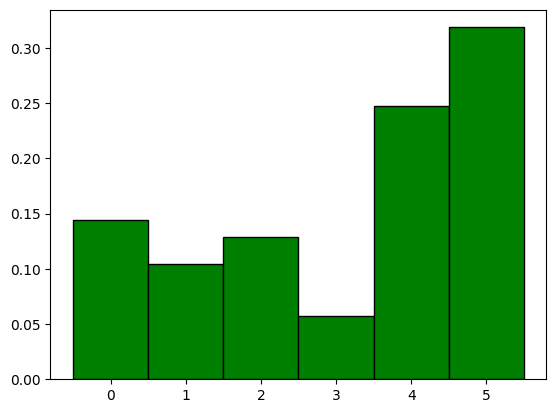

P-val (rejection): 0.2058980778482995


In [14]:
def discrete_rejection(n, p):
    c = np.max(p)
    k = len(p)

    vals = np.empty(n)
    for j in range(n):
        while True:
            i = int(np.floor(k * uniform.rvs())) # int may just round down on its own, but better safe than sorry
            if uniform.rvs() <= p[i] / c:
                vals[j] = i
                break

    return vals

rejection_vals = discrete_rejection(n, P)
plt.hist(rejection_vals, bins=np.arange(len(P)+1)-0.5, edgecolor='black', density=True, color='green')
plt.show()
print("P-val (rejection):", chi2_test(rejection_vals, P))

The bars are almost identifical to the ones in the histogram from the previous assignment, suggesting this method also correctly maps uniform random values to the specified discrete distribution. Once again, the p-value is high, suggesting the data is consistent with the distribution of $P$.

$\textbf{(c)}$ Now, the Alias method is used to sample from a discrete distribution with unequal probabilities. It involves a preprocessing step where two tables are constructed: a probability table \( F \), and an alias table \( L \):

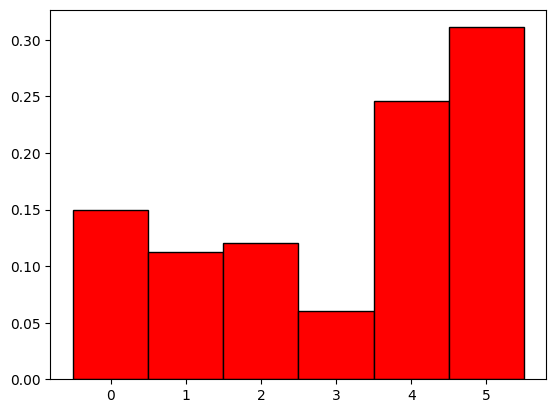

P-val (alias)    : 0.04804119760461445


In [18]:
def generate_f_and_l(p):
    k = len(p)
    L = np.arange(k)
    F = p * k
    G = np.where(F >= 1)[0]
    S = np.where(F <= 1)[0]

    while S.size:
        i = G[0]
        j = S[0]
        L[j] = i
        F[i] = F[i] - (1 - F[j])
        if F[i] < 1 - 1e-8:
            G = G[1:]
            S = np.append(S, np.array([i]))
        S = S[1:]

    return F, L

def discrete_alias(n, f, l):
    k = len(f)
    
    vals = np.empty(n)
    for j in range(n):
        i = int(np.floor(k * uniform.rvs()))
        if uniform.rvs() <= f[i]:
            vals[j] = i
        else:
            vals[j] = l[i]

    return vals

fs, ls = generate_f_and_l(P)
alias_vals = discrete_alias(n, fs, ls)

plt.hist(alias_vals, bins=np.arange(len(P)+1)-0.5, edgecolor='black', density=True, color='red')
plt.show()
print("P-val (alias)    :", chi2_test(alias_vals, P))

Again, this matches the previous assignments, proving the Alias method is also capable of correctly mapping uniform random values to the specified discrete distribution. The low p-value, however, does indicate that the generated data does not follow the distribution of $P$.

### 3. Compare the three different methods using adequate criteria, then discuss the results.

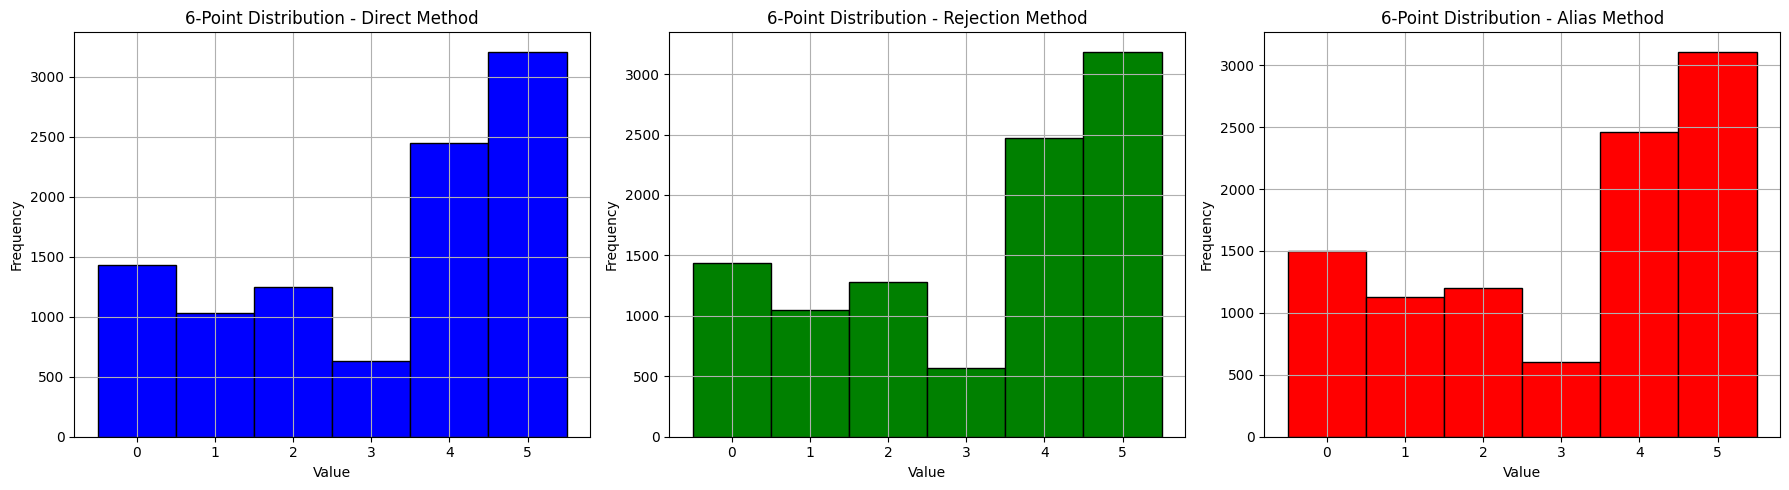

Method       Chi2 p-value    KL Divergence   MAE       
Direct       0.573869        0.000191        28.67     
Rejection    0.205898        0.000366        33.44     
Alias        0.048041        0.000551        41.00     


In [32]:
samples_direct = crude_vals
samples_rejection = rejection_vals
samples_alias = alias_vals

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

method_names = ['Direct Method', 'Rejection Method', 'Alias Method']  
sample_sets = [samples_direct, samples_rejection, samples_alias]
colors = ['blue', 'green', 'red']
X = np.arange(6)  
bins = np.arange(6)

for i in range(3):
    axs[i].hist(sample_sets[i], bins=np.arange(len(P)+1)-0.5, edgecolor='black', rwidth=1, color=colors[i])
    axs[i].set_title(f"6-Point Distribution - {method_names[i]}")
    axs[i].set_xticks(X)
    axs[i].set_xlabel("Value")
    axs[i].set_ylabel("Frequency")
    axs[i].grid(True)

plt.tight_layout()
plt.show()

method_samples = {
    "Direct": samples_direct,
    "Rejection": samples_rejection,
    "Alias": samples_alias
}

print(f"{'Method':<12} {'Chi2 p-value':<15} {'KL Divergence':<15} {'MAE':<10}")

for name, sample in method_samples.items(): 
    obs_counts = np.array([np.sum(sample == xi) for xi in bins])
    expected_freq = P * len(sample)
    chi2_stat, chi2_p = chisquare(f_obs=obs_counts, f_exp=expected_freq)
    obs_dist = obs_counts / len(sample)
    kl = entropy(obs_dist + 1e-10, P)
    mae = np.mean(np.abs(obs_counts - expected_freq))
    print(f"{name:<12} {chi2_p:<15.6f} {kl:<15.6f} {mae:<10.2f}")


All three methods approximate the target 6-point distribution, but with varying levels of accuracy. 

The direct method provides a good match, with a reasonable chi-square p-value, low KL divergence, and moderate MAE. 

The rejection method also produces a valid distribution with a semi-high p-value and a low KL divergence, with a moderate MAE.

The Alias has the lowest p-value of the bunch, meaning the distribution does not indicate to follow the distribution of $P$. However, the metric for KL divergence is decent. It has the highest MAE. 

In conclusion, this proves that the Direct method is the most accurate and efficient among the three for repeated sampling while retaining to the form of $P$.

### 4. Give recommendations of how to choose the best suite method in different settings, i.e., discuss the advantages and drawbacks of each method. If time permits substantiate by running experiments.

The direct method proved the best.

# Exercise 3

## 1. Generate simulated values from the following distributions
### (a) Exponential distribution
### (b) Normal distribution (at least with standard Box-Mueller)
### (c) Pareto distribution, with β = 1 and experiment with different values of k values: k = 2.05, k = 2.5, k = 3 and k = 4.
## Verify the results by comparing histograms with analytical results and perform tests for distribution type.

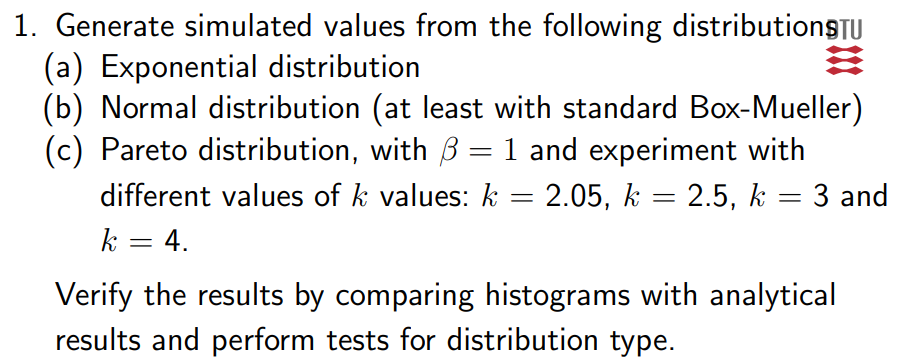

$\textbf{(a)}$ To genereate values from an exponential distribution, we use the inverse transform method. We know that the exponential distribution has the following CDF:
$$
F(x) = 1-e^{-\lambda x}
$$
If we solve for $x=F^{-1}(u)$, we get:
$$
x=-\frac{1}{\lambda}\log (U), \quad U\sim \text{Uniform}(0,1)
$$


For simplicity's sake, we set $\lambda = 1$ and do $n=10000$ runs. We plot the distribution of generated values together with the theoreitcal PDF, and also do a KS test:

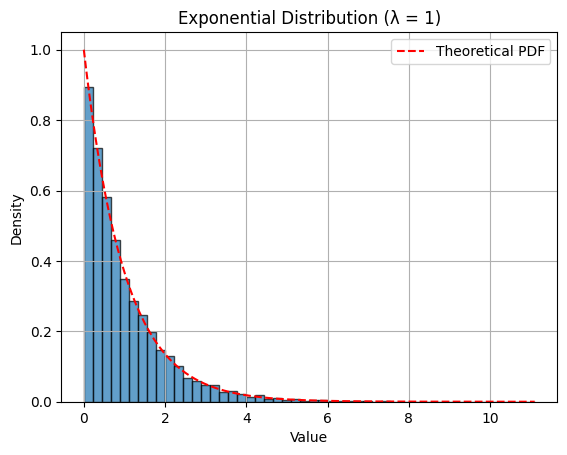

KS test p-value: 0.7526


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, kstest, norm
n = 10000
lam = 1

U = np.random.uniform(0, 1, n)
samples = -np.log(U) / lam  

plt.hist(samples, bins=50, edgecolor='black', alpha=0.7, density=True)
x = np.linspace(0, np.max(samples), 200)
plt.plot(x, expon.pdf(x, scale=1/lam), 'r--', label='Theoretical PDF')
plt.title("Exponential Distribution (λ = 1)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

D, p = kstest(samples, 'expon', args=(0, 1/lam))
print(f"KS test p-value: {p:.4f}")

As can be observed, the simulated values from the exponential distribution with $\lambda = 1$ match the theoretical PDF, and the high KS test p-value confirms an excellent fit of the distribution. 

$\textbf{(b)}$ Here, we do the same but for a normal distribution with a standard Box-Mueller transformation. Specifically, the Box-Mueller transform is a method to generate samples from a standard normal distribution using two independent uniform random variables, $U_1 , U_2 \sim \text{Uniform}(0,1)$. After these have been generated, then $Z_1$ and $Z_2$ are computed:
$$
Z_1 = \sqrt{-2 \log U_1} \cos (2\pi U_2)
$$
$$
Z_2 = \sqrt{-2 \log U_1} \sin (2\pi U_2)
$$
In turn, $Z_1, Z_2 \sim \text{N}(0,1)$

We generate 10000 values using this method:

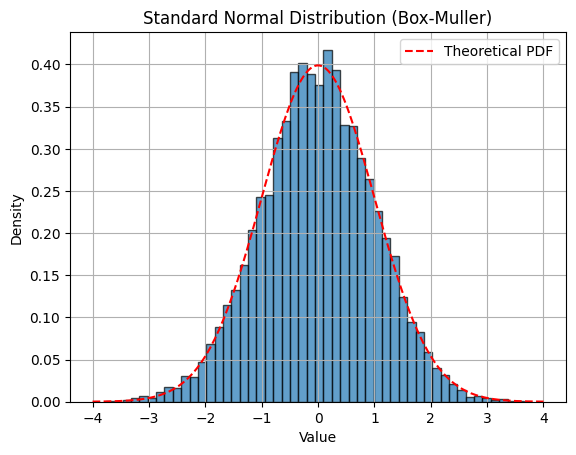

KS test p-value: 0.7394


In [6]:
U1 = np.random.uniform(0, 1, n//2)
U2 = np.random.uniform(0, 1, n//2)

Z1 = np.sqrt(-2 * np.log(U1)) * np.cos(2 * np.pi * U2)
Z2 = np.sqrt(-2 * np.log(U1)) * np.sin(2 * np.pi * U2)
samples = np.concatenate([Z1, Z2])

plt.hist(samples, bins=50, density=True, edgecolor='black', alpha=0.7)
x = np.linspace(-4, 4, 200)
plt.plot(x, norm.pdf(x), 'r--', label='Theoretical PDF')
plt.title("Standard Normal Distribution (Box-Muller)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.show()

D, p = kstest(samples, 'norm')
print(f"KS test p-value: {p:.4f}")

This shows that the Box-Mueller method is capable of accurately generating samples from the standard normal distribution, as the theoretical pdf matches closely to the 10000 generated values. Furthermore, the KS test value indicates no significant devation from normality.

$\textbf{(c)}$ Now, we generate 10000 values using the Pareto distribution 

In the textbook, the CDF of the Pareto distribution is
$$
F(x) = 1-(\frac{\beta}{x})^k , \quad \text{for}\ x\geq\beta 
$$

When executing the inverse transformation of this, the following is reached:

Solving this for $x$ results in:
$$
x = \frac{\beta}{(1-U)^{1/k}}
$$
Here, $U\sim\text{Uniform}(0,1)$.

Using this, 10000 values can be created for each different value of $k$:

KS test p-value for k = 2.05: 0.1056
KS test p-value for k = 2.5: 0.2007
KS test p-value for k = 3: 0.8369
KS test p-value for k = 4: 0.2425


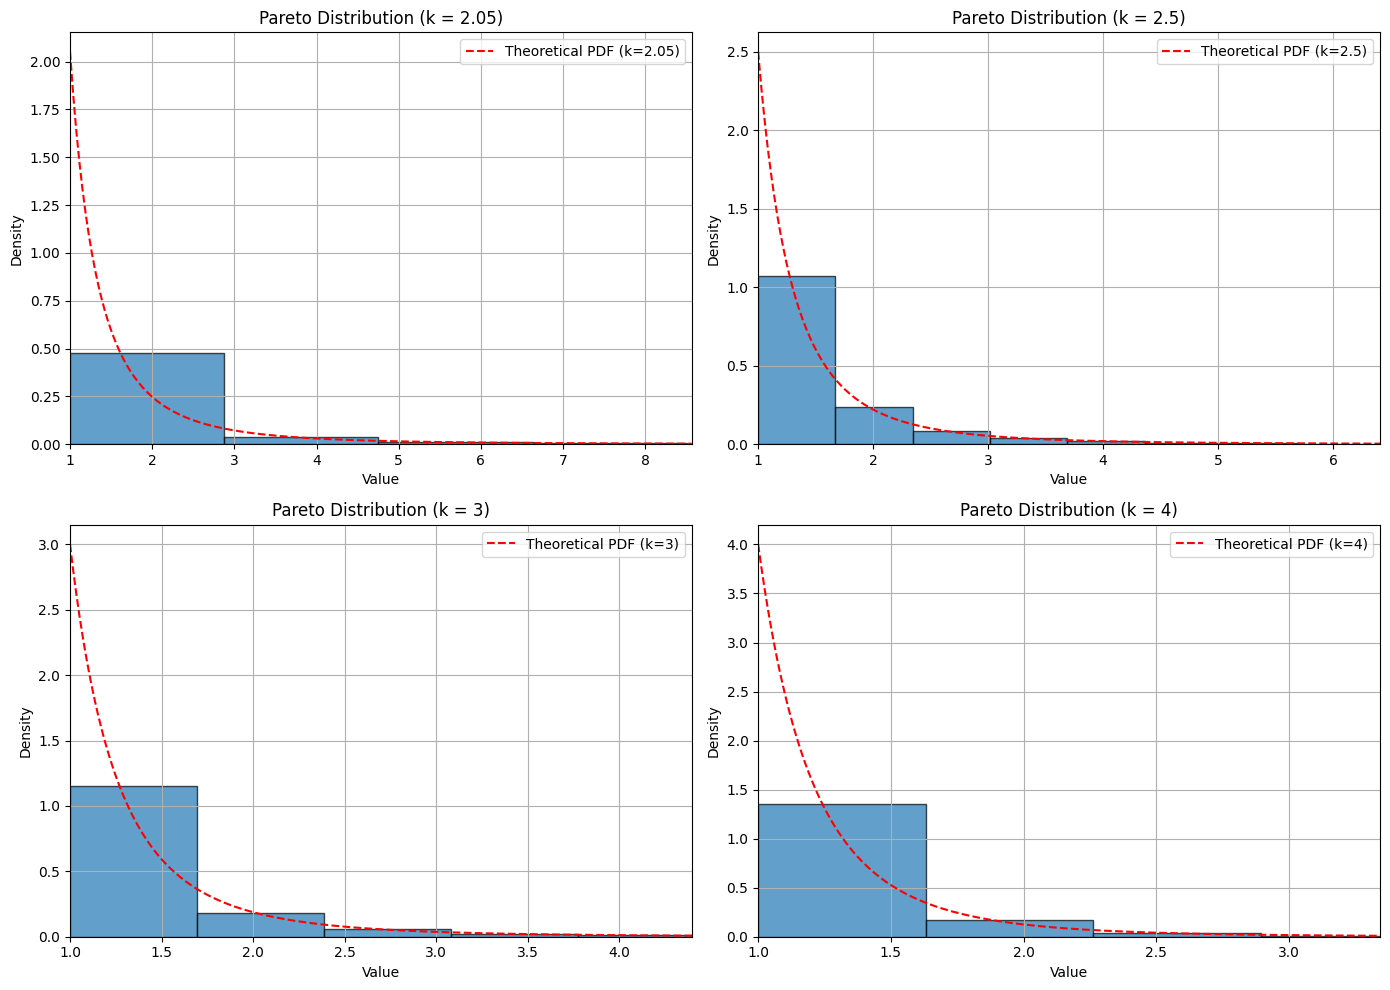

In [9]:
k_values = [2.05, 2.5, 3, 4]
beta = 1

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, k in enumerate(k_values):
    U = np.random.uniform(0, 1, n)
    samples = beta / ((1 - U) ** (1 / k))
    x_max = np.percentile(samples, 99)  
    x = np.linspace(beta, x_max, 200)

    axs[i].hist(samples, bins=50, density=True, alpha=0.7, edgecolor='black')
    axs[i].plot(x, pareto.pdf(x, b=k, scale=beta), 'r--', label=f'Theoretical PDF (k={k})')
    axs[i].set_title(f'Pareto Distribution (k = {k})')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Density')
    axs[i].set_xlim([beta, x_max])     
    axs[i].grid(True)
    axs[i].legend()

    D, p = kstest(samples, 'pareto', args=(k, 0, beta))
    print(f"KS test p-value for k = {k}: {p:.4f}")

plt.tight_layout()
plt.show()

The histograms show that the simulated Pareto distributions closely follow the theoretical PDFs for all tested $k$. As $k$ increases, the tail becomes thinner and the distribution becomes more concentrated near 1. The KS test p-values are all above 0.05, confirming that the samples are consistent with the target Pareto distributions.

### 2. For the Pareto distribution with support on [β,∞[ compare mean value and variance, with analytical results, which can be calculated as E(X) = β* k/(k-1)  (for k > 1) and Var(X) = β^2 * (k/((k-1)^2 (k-2)). Explain problems if any

Now, we compared the analytical results with the mean and variance of the Pareto distirubtion, E(X) and Var(X), with the 4 different values of $k$ and $\beta=1$:

In [10]:
print(f"{'k':<6} {'Empirical Mean':<18} {'Theoretical Mean':<20} {'Empirical Var':<18} {'Theoretical Var'}")

for k in k_values:
    U = np.random.uniform(0, 1, n)
    samples = (1 / (1 - U))**(1 / k)

    empirical_mean = np.mean(samples)
    empirical_var = np.var(samples)

    if k > 1:
        theoretical_mean = beta * k / (k - 1)
    else:
        theoretical_mean = np.nan

    if k > 2:
        theoretical_var = (beta**2) * k / ((k - 1)**2 * (k - 2))
    else:
        theoretical_var = np.nan

    print(f"{k:<6} {empirical_mean:<18.4f} {theoretical_mean:<20.4f} {empirical_var:<18.4f} {theoretical_var}")

k      Empirical Mean     Theoretical Mean     Empirical Var      Theoretical Var
2.05   1.9223             1.9524               4.7468             37.18820861678019
2.5    1.6444             1.6667               1.7075             2.2222222222222223
3      1.5046             1.5000               0.7317             0.75
4      1.3359             1.3333               0.2227             0.2222222222222222


For all values of $k$, the empirical means closely match the theoretical means, confirming a succesful simulation. However, for $k=2.05$, while the mean exists, the theoretical variance is extremely sensitive due to the heavy tail. This results in a very large empirical variance despite a relatively low theoretical value, highlighting the overall instability. For higher values of $k \geq 2.5$, both mean and variance align well with theoretical expectations, and the distribution behaves more stably. This demonstrates that as $k$ becomes higher, the theoretical moments approach the empirical more and more.

### 3. For the normal distribution generate 100 95% confidence intervals for the mean and variance, each based on 10 observations. Discuss the results

To generate 100 95%-confidence intervals for mean and variance, we do:

In [13]:
n = 10
N = 100  
true_mean = 0
true_var = 1

mean_contains = 0
var_contains = 0

alpha = 0.05
t_crit = t.ppf(1 - alpha / 2, df=n - 1)

for _ in range(N):
    data = np.random.normal(0, 1, n)
    xbar = np.mean(data)
    s = np.std(data, ddof=1)
    s2 = np.var(data, ddof=1)

    ci_mean = (xbar - t_crit * s / np.sqrt(n), xbar + t_crit * s / np.sqrt(n))
    if ci_mean[0] <= true_mean <= ci_mean[1]:
        mean_contains += 1

    chi2_lower = chi2.ppf(alpha / 2, df=n - 1)
    chi2_upper = chi2.ppf(1 - alpha / 2, df=n - 1)
    ci_var = ((n - 1) * s2 / chi2_upper, (n - 1) * s2 / chi2_lower)
    if ci_var[0] <= true_var <= ci_var[1]:
        var_contains += 1

print(f"Mean CI coverage: {mean_contains} / {N}")
print(f"Variance CI coverage: {var_contains} / {N}")

Mean CI coverage: 92 / 100
Variance CI coverage: 95 / 100


Out of 100 simulations, 92 out of 100 confidence intervals for the means contained the true population mean, which is 0.

And out of the 100 simulation, 95 out of 100 confidence intervals for the variance contained the true population mean, which is 1.

This shows that not every time the 95% confidence intervals capture the true parameter, but they do do it succesfully 95% of the time. If we were to increase $N$, we would approximate 95 better.

### 4. Simulate from the Pareto distribution using composition.

Composition means constructing a random variable by transforming or combining simpler random variables. Specifically, we use the inverse transform method on the Pareto distribution, where we compose it from a uniform distribution like so:
$$
X = \frac{1}{U^{1/k}}, \quad \text{with } U \sim \text{Uniform}(0,1)
$$

We simulate this for $n=10000$ runs and set $k=3$ and $\beta=1$

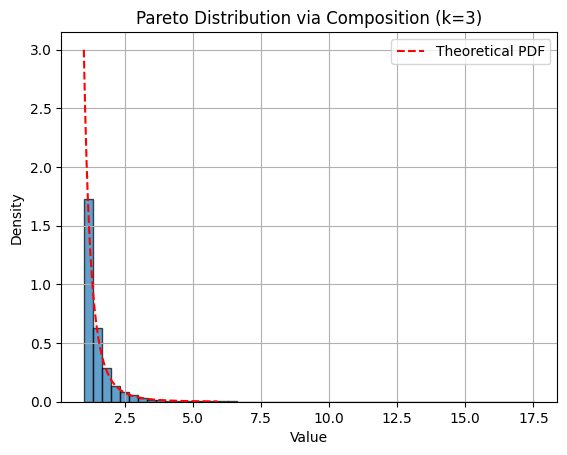

KS test p-value: 0.3846


In [14]:
n = 10000
k = 3
beta = 1

U = np.random.uniform(0, 1, n)
X = beta / U**(1 / k)  # Composition method

x = np.linspace(1, np.percentile(X, 99.5), 200)
plt.hist(X, bins=50, density=True, edgecolor='black', alpha=0.7)
plt.plot(x, pareto.pdf(x, b=k, scale=beta), 'r--', label='Theoretical PDF')
plt.title(f'Pareto Distribution via Composition (k={k})')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

D, p = kstest(X, 'pareto', args=(k, 0, beta))
print(f"KS test p-value: {p:.4f}")

Here, we see the generated samples follow the theoretical PDF. Furthermore, the high KS indicates that the generated values are in fact consistent with a Pareto distribution.